In [355]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from itertools import product
from tqdm import tqdm

from src.utils import load_data, cost_function

DATA_PATH = os.path.join(os.curdir, 'data')
random_state = 42
np.random.seed(random_state)

In [5]:
X_train, y_train, X_test = load_data(DATA_PATH)
ds_train = pd.concat([y_train.rename(columns={0:"target"}), X_train], axis=1)

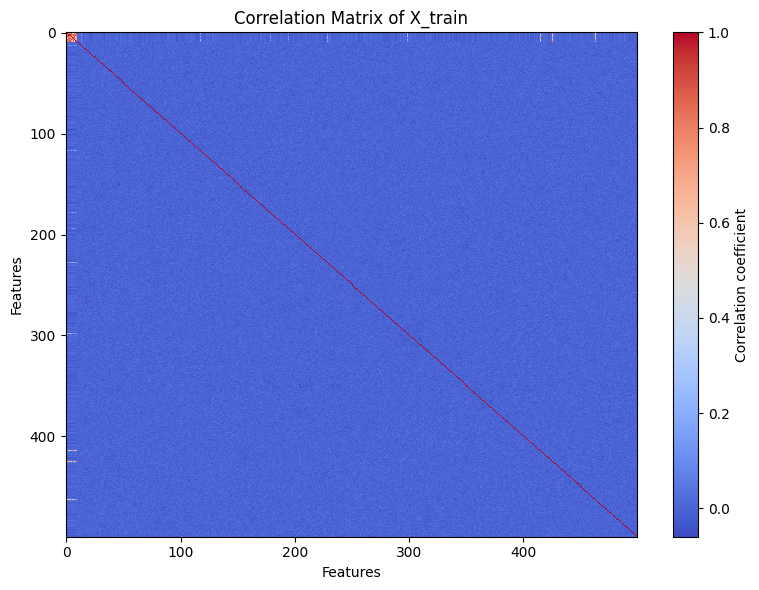

In [6]:
plt.figure(figsize=(8, 6))
corr_matrix = X_train.corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix of X_train')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [7]:
corr_matrices = []

for i, method in enumerate(['pearson', 'spearman']):
    corr_matrix = ds_train.corr(method=method)
    corr_method = corr_matrix["target"].sort_values(ascending=False)
    corr_method = corr_method.drop(index='target', axis=0).abs().reset_index()
    corr_matrices.append(corr_method)

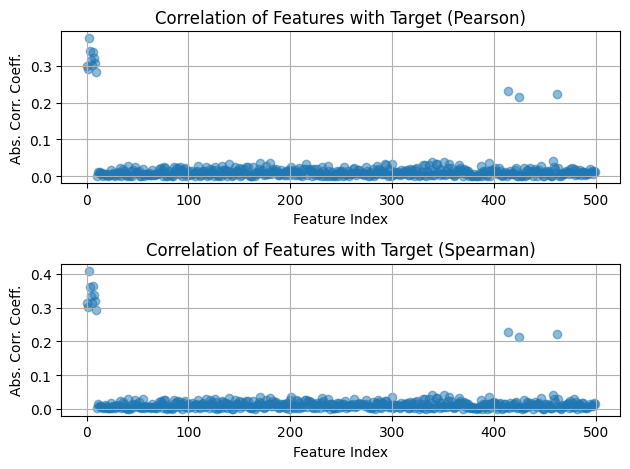

In [8]:
for i, method in enumerate(['pearson',  'spearman']):
    plt.subplot(len(corr_matrices), 1, i + 1)
    plt.scatter(corr_matrices[i]['index'], corr_matrices[i]['target'], alpha=0.5)
    plt.title(f'Correlation of Features with Target ({method.capitalize()})')
    plt.xlabel('Feature Index')
    plt.ylabel('Abs. Corr. Coeff.')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
corr_matrix = corr_matrices[0]
feature_indices = [int(x) for x in corr_matrix[corr_matrix['target'] >= 0.1]['index'].values]
n = len(feature_indices)
print(f"Top {n} features with highest correlation with target (Pearson):")
print(feature_indices)

Top 13 features with highest correlation with target (Pearson):
[2, 3, 6, 7, 4, 8, 5, 0, 1, 9, 414, 462, 425]


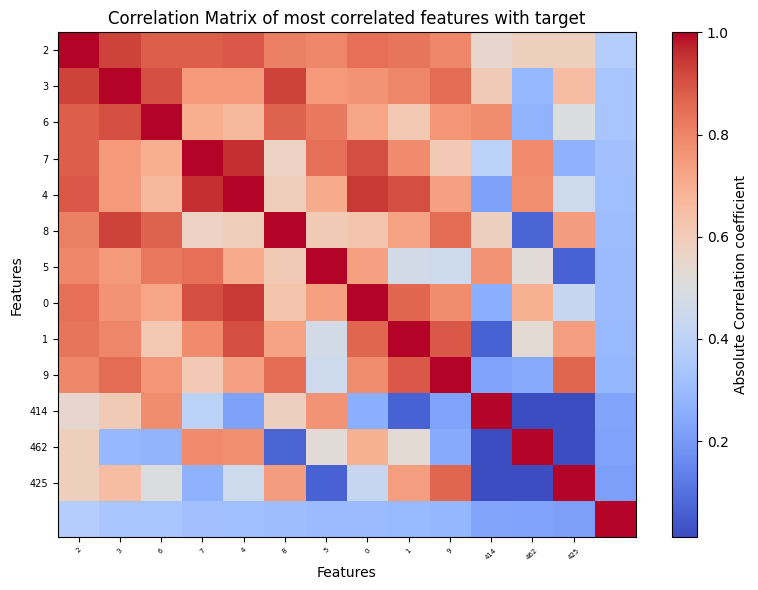

In [123]:
plt.figure(figsize=(8, 6))
corr_matrix = ds_train.corr().abs()
feature_indices_and_target = feature_indices + ['target']
plt.imshow(corr_matrix[feature_indices_and_target].loc[feature_indices_and_target], cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Absolute Correlation coefficient')
plt.title('Correlation Matrix of most correlated features with target')
plt.xticks(range(len(feature_indices)), feature_indices, rotation=45, size=5)
plt.yticks(range(len(feature_indices)), feature_indices, size=7)
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Hyperparameters tuning

In [ ]:
def preprocess_features(X: pd.DataFrame, y: pd.DataFrame, feature_indices: list[int]):
    X_np = StandardScaler().fit_transform(X.to_numpy()[:, feature_indices])
    y_np = y.to_numpy().astype(np.int32).ravel()
    return X_np, y_np

In [ ]:
X_train_np, y_train_np = preprocess_features(X_train, y_train, feature_indices)

In [353]:
def finetune_params(model, X: np.ndarray, y: np.ndarray, param_grid: dict):
    """
    Finetune parameters for the model using cross-validation and a cost function.

    :param model: The model to be finetuned.
    :param np.ndarray X: Feature matrix.
    :param np.ndarray y: Target vector.
    :param dict param_grid: Dictionary with parameter names as keys and lists of parameter values as values.
    :return best_score, best_params: Tuple of best score and best parameters.
    """
    best_score = 0
    best_params = None
    for params in tqdm(list(product(*param_grid.values())), desc=f"{type(model).__name__} Finetuning parameters"):
        param_dict = dict(zip(param_grid.keys(), params))
        model.set_params(**param_dict)
        scores = cross_val_predict(model, X, y, cv=5, method='predict_proba', n_jobs=-1)
        score = cost_function(y, scores[:, 1], X.shape[1])
        if score > best_score:
            best_score = score
            best_params = param_dict
    return best_score, best_params

1. Plot of score with one feature with xgb, lr, svm, random forest, lda, qda

In [418]:
def finetune_model(model_class: BaseEstimator, param_grid_stages: list[dict]):
    overall_best_score = 0
    overall_best_params = {}
    model_name = model_class.__name__

    for i, param_grid in enumerate(param_grid_stages):
        print(f"{model_name} Finetuning parameters for stage {i + 1}...")
        model = model_class(random_state=random_state)
        model.set_params(**overall_best_params)
        best_score, best_params = finetune_params(model, X_train_np, y_train_np, param_grid)
        print(f"{model_name} Best parameters for stage {i + 1} with score {best_score}: {best_params}")
        model.set_params(**best_params)
        overall_best_params.update(best_params)
        overall_best_score = max(best_score, overall_best_score)

    return overall_best_params, overall_best_score

In [ ]:
configs = [
    {
        "model_class": LogisticRegression,
        "param_grid_stages": [
            # Regularization Type & Strength
            {
                'penalty': ['elasticnet', None],
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['saga'],
                'l1_ratio': [0.0, 0.1, 0.5, 0.9, 1.0]
            },
            {
                'class_weight': [None, 'balanced']
            },]
    },
    {
        "model_class": RandomForestClassifier,
        "param_grid_stages": [
            # Tree Depth & Number
            {
                'n_estimators': [100, 300, 500],
                'max_depth': [None, 5, 10, 20],
            },
            # Splitting & Feature Selection
            {
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': [None, 'sqrt', 'log2'],
            },
            # Class Imbalance
            {
                'class_weight': [None, 'balanced', 'balanced_subsample']
            }]
    },
    {
        "model_class": xgb.XGBClassifier,
        "param_grid_stages": [
            # Tree structure
            {
                'max_depth': np.linspace(1, 10, 10, dtype=int).tolist(),
                'min_child_weight': [1, 2, 3, 4, 5]
            },
            # Regularization
            {
                'gamma': [0, 0.1, 0.3],
                'alpha': [0.0] + np.logspace(-2, 3, 6).tolist(),
                'lambda': np.linspace(0, 50, 10).tolist()
            },
            # Subsampling
            {
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.4, 0.6, 0.8, 1.0]
            },
            # Learning rate
            {
                'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
            }]
    },
]

In [420]:
def scoring(model: BaseEstimator, X: np.ndarray, y: np.ndarray) -> float:
    y_proba = model.predict_proba(X)
    return cost_function(y, y_proba[:, 1], X.shape[1])

In [421]:
results = {}
rfes = {}

for config in configs:
    model_class, param_grid_stages = config["model_class"], config["param_grid_stages"]
    best_params, best_score = finetune_model(model_class, param_grid_stages)
    model_name = model_class.__name__
    results[model_name] = (best_params, best_score)
    rfe = RFECV(
        estimator=model_class(random_state=random_state, **best_params),
        cv=5,
        scoring=scoring,
        n_jobs=1,
    ).fit(X_train_np, y_train_np)
    print(f"{model_name} best features:", rfe.get_feature_names_out(feature_indices))
    rfes[model_name] = rfe

XGBClassifier Finetuning parameters for stage 1...


XGBClassifier Finetuning parameters: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


XGBClassifier Best parameters for stage 1 with score 4920: {'max_depth': 3, 'min_child_weight': 2}
XGBClassifier Finetuning parameters for stage 2...


XGBClassifier Finetuning parameters: 100%|██████████| 210/210 [00:21<00:00,  9.94it/s]


XGBClassifier Best parameters for stage 2 with score 4960: {'gamma': 0.3, 'alpha': 10.0, 'lambda': 22.22222222222222}
XGBClassifier Finetuning parameters for stage 3...


XGBClassifier Finetuning parameters: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


XGBClassifier Best parameters for stage 3 with score 4960: {'subsample': 1.0, 'colsample_bytree': 1.0}
XGBClassifier Finetuning parameters for stage 4...


XGBClassifier Finetuning parameters: 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


XGBClassifier Best parameters for stage 4 with score 4960: {'learning_rate': 0.3}
XGBClassifier best features: [2]


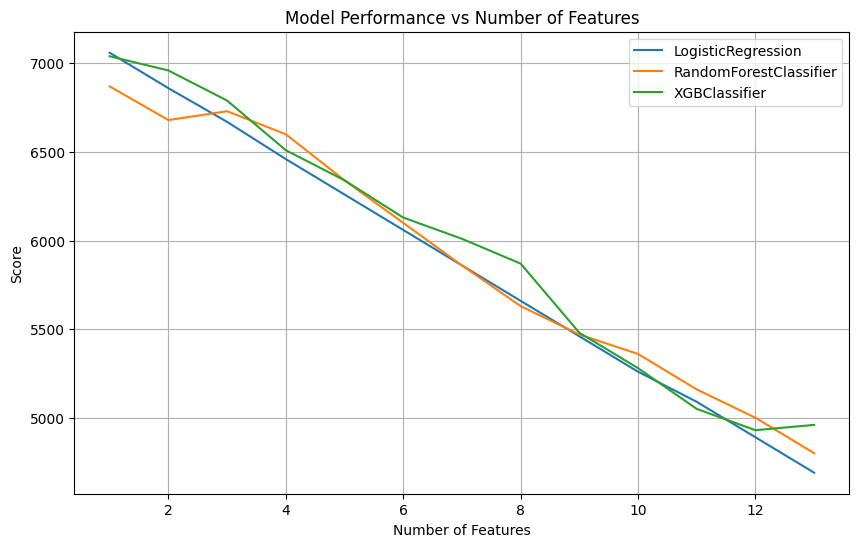

In [ ]:
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": xgb.XGBClassifier,
}
scores = {name: [] for name in models.keys()}

for model_name, rfe in rfes.items():
    best_params = results[model_name][0]
    features_ranking = [rank - 1 for rank in rfe.ranking_]
    features_ranking_names = [None]*X_train_np.shape[1]
    for i, rank in enumerate(features_ranking):
        features_ranking_names[rank] = feature_indices[i]
    print(f"{model_name} Features ranked:", features_ranking_names)
    for i in range(len(features_ranking)):
        features = features_ranking[:i+1]
        y_proba = cross_val_predict(models[model_name](**best_params),
                                    X_train_np[:, features], y_train_np,
                                    cv=5, method='predict_proba', n_jobs=-1)
        score = cost_function(y_train_np, y_proba[:, 1], i+1)
        scores[model_name].append(score)

plt.figure(figsize=(10, 6))
for model_name, score in scores.items():
    plt.plot(range(1, len(score) + 1), score, label=model_name)
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [437]:
for model_name, rfe in rfes.items():
    print(f"For {model_name}:")
    best_params = results[model_name][0]
    print("\tBest params:", best_params)
    print("\tBest feature set:", rfe.get_feature_names_out(feature_indices))

    features_ranking = [rank - 1 for rank in rfe.ranking_]
    features_ranking_names = [None]*X_train_np.shape[1]
    for i, rank in enumerate(features_ranking):
        features_ranking_names[rank] = feature_indices[i]
    print("\tFeatres ranking:", features_ranking_names)
    print("\tBest score:", max(scores[model_name]))

For LogisticRegression:
	Best params: {'penalty': 'elasticnet', 'C': 0.01, 'solver': 'saga', 'l1_ratio': 1.0, 'class_weight': None}
	Best feature set: [2]
	Featres ranking: [2, 6, 414, 425, 462, 7, 9, 1, 0, 5, 8, 4, 3]
	Best score: 7060
For RandomForestClassifier:
	Best params: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': None}
	Best feature set: [2]
	Featres ranking: [2, 3, 6, 4, 7, 8, 462, 425, 0, 414, 5, 1, 9]
	Best score: 6870
For XGBClassifier:
	Best params: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.3, 'alpha': 10.0, 'lambda': 22.22222222222222, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.3}
	Best feature set: [2]
	Featres ranking: [2, 414, 462, 6, 425, 7, 4, 8, 0, 3, 9, 5, 1]
	Best score: 7040
